# Recap

Raw sequencing data (`.fastq.gz`) mapped to a reference genome (`.fa.gz`) with `bwa`, creating files with mapped reads(`.bam`)

`samtools` to inspect, sort, merge, filter them

`gatk MarkDuplicates` to mark or remove PCR duplicates from the data

`mosdepth` to get coverage

Genotype calling: what is the state of an individual at a given position in the genome?

Program: `gatk HaplotypeCaller` - needs reference genome and mapped data

Output: Variant Call File (`.vcf.gz`)

`bcftools` as toolkit for inspection, filtering, etc.

`bcftools view` - can include parameters for filtering, e.g. `-m2` means at least 2 alleles

`bcftools concat` - concatenate files

`bcftools stats` - obtain useful statistics


# VCF file formats

We had generated two common types of VCF file outputs using the GATK `ERC` parameters: `BP_RESOLUTION` and `NONE`. One gives a genotype call for each position along the chromosome, the other only for positions that are different from the reference genome. The problem with the first is that it creates large files in which most positions are the same as the reference. The problem with the second is that we miss exactly where they are the same. A compromise is using the format `GVCF`, which creates a hybrid file format, in which consecutive `0/0` positions are merged.

* If not done as part of the last challenge, you may create this file by using this parameter now, for the region 1-25000000.

* Do you have it? Otherwise, we may have a look at it together.

This format is very efficient for storing large data, but it creates a mess in terms of coordinates. At more advanced levels, other tools from the `gatk` (it's a toolkit) are necessary to handle this kind of information. Also, some commands of `bcftools` need to know what is going on, *e.g.* if you want to use this program to merge data from multiple individuals.

* Now, also get the genotypes in the same format for any of the `.bam` files from the previous sessions!


## Merging

To clarify the difference between `bcftools concat` and `bcftools merge`: you concatenate different genomic positions for the same individuals, or your merge the same genomic positions for different individuals.

**Concatenating:**
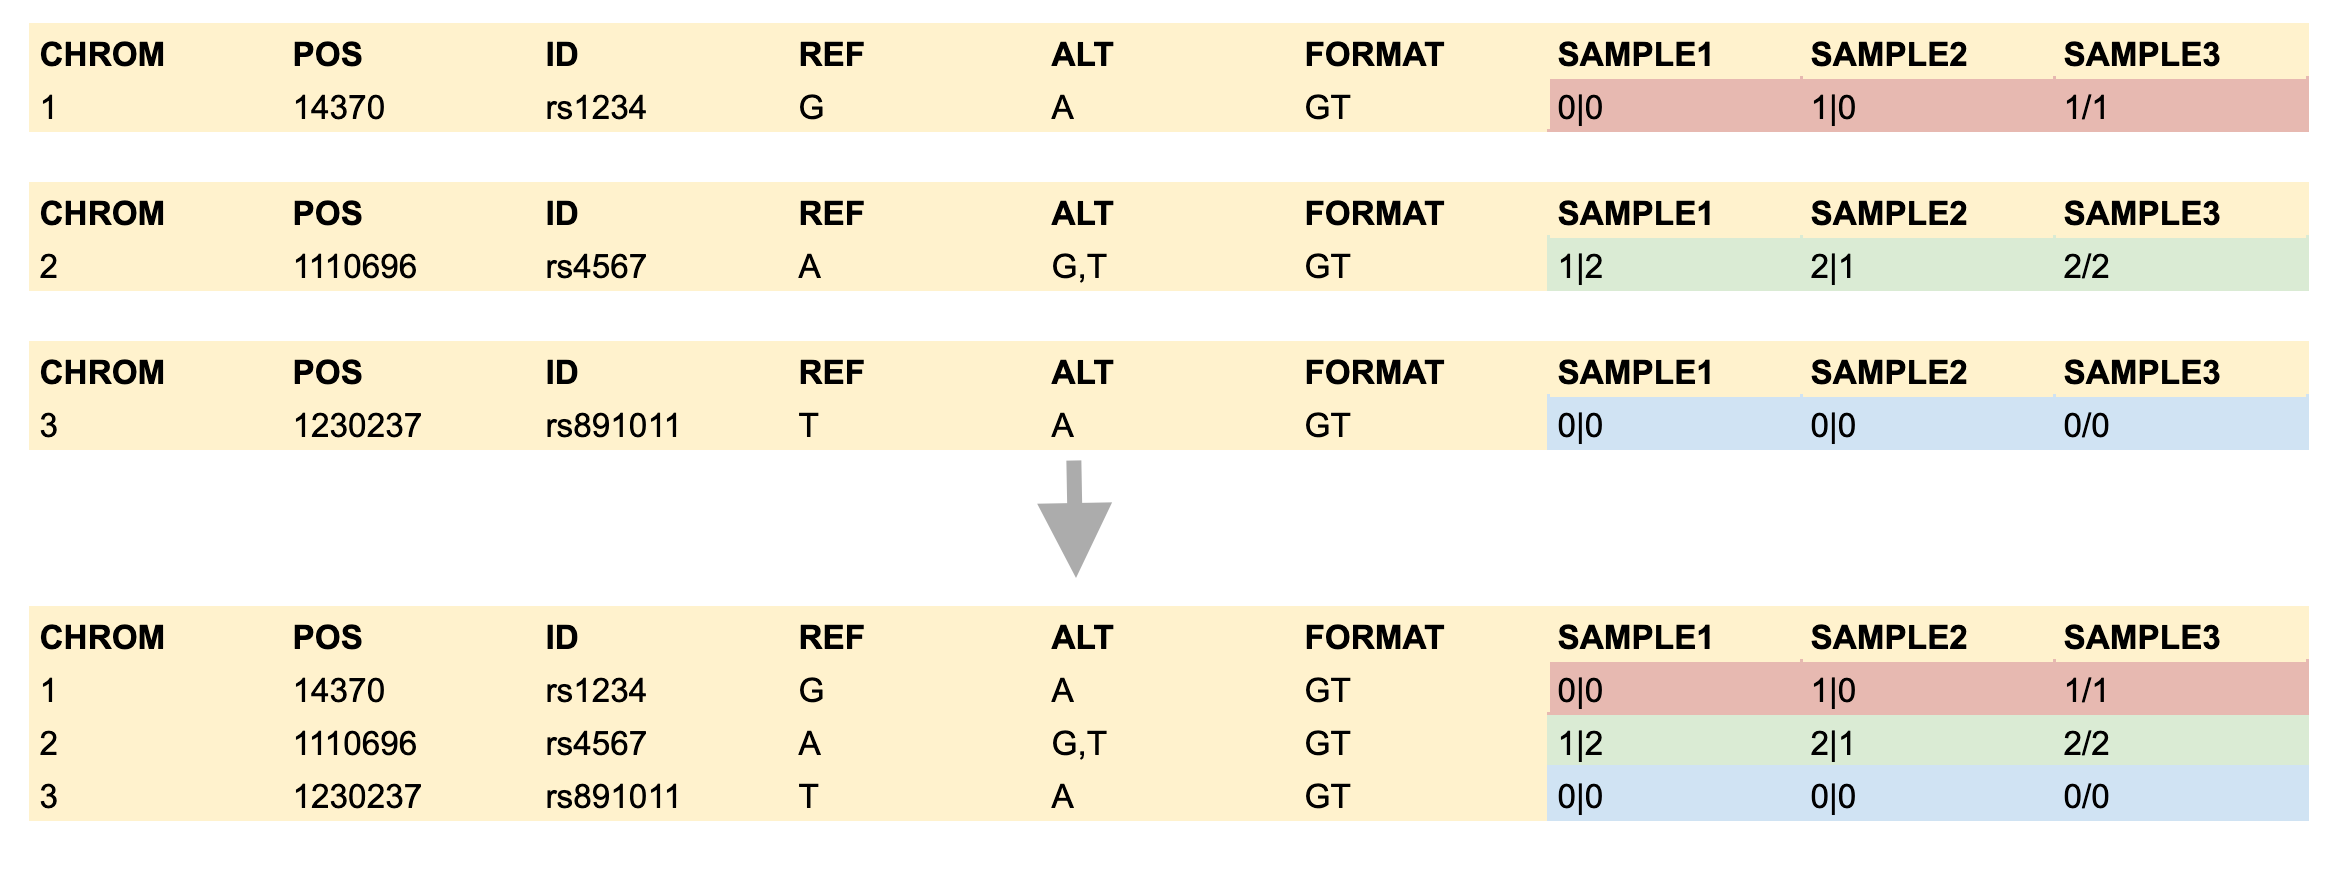

**Merging:**
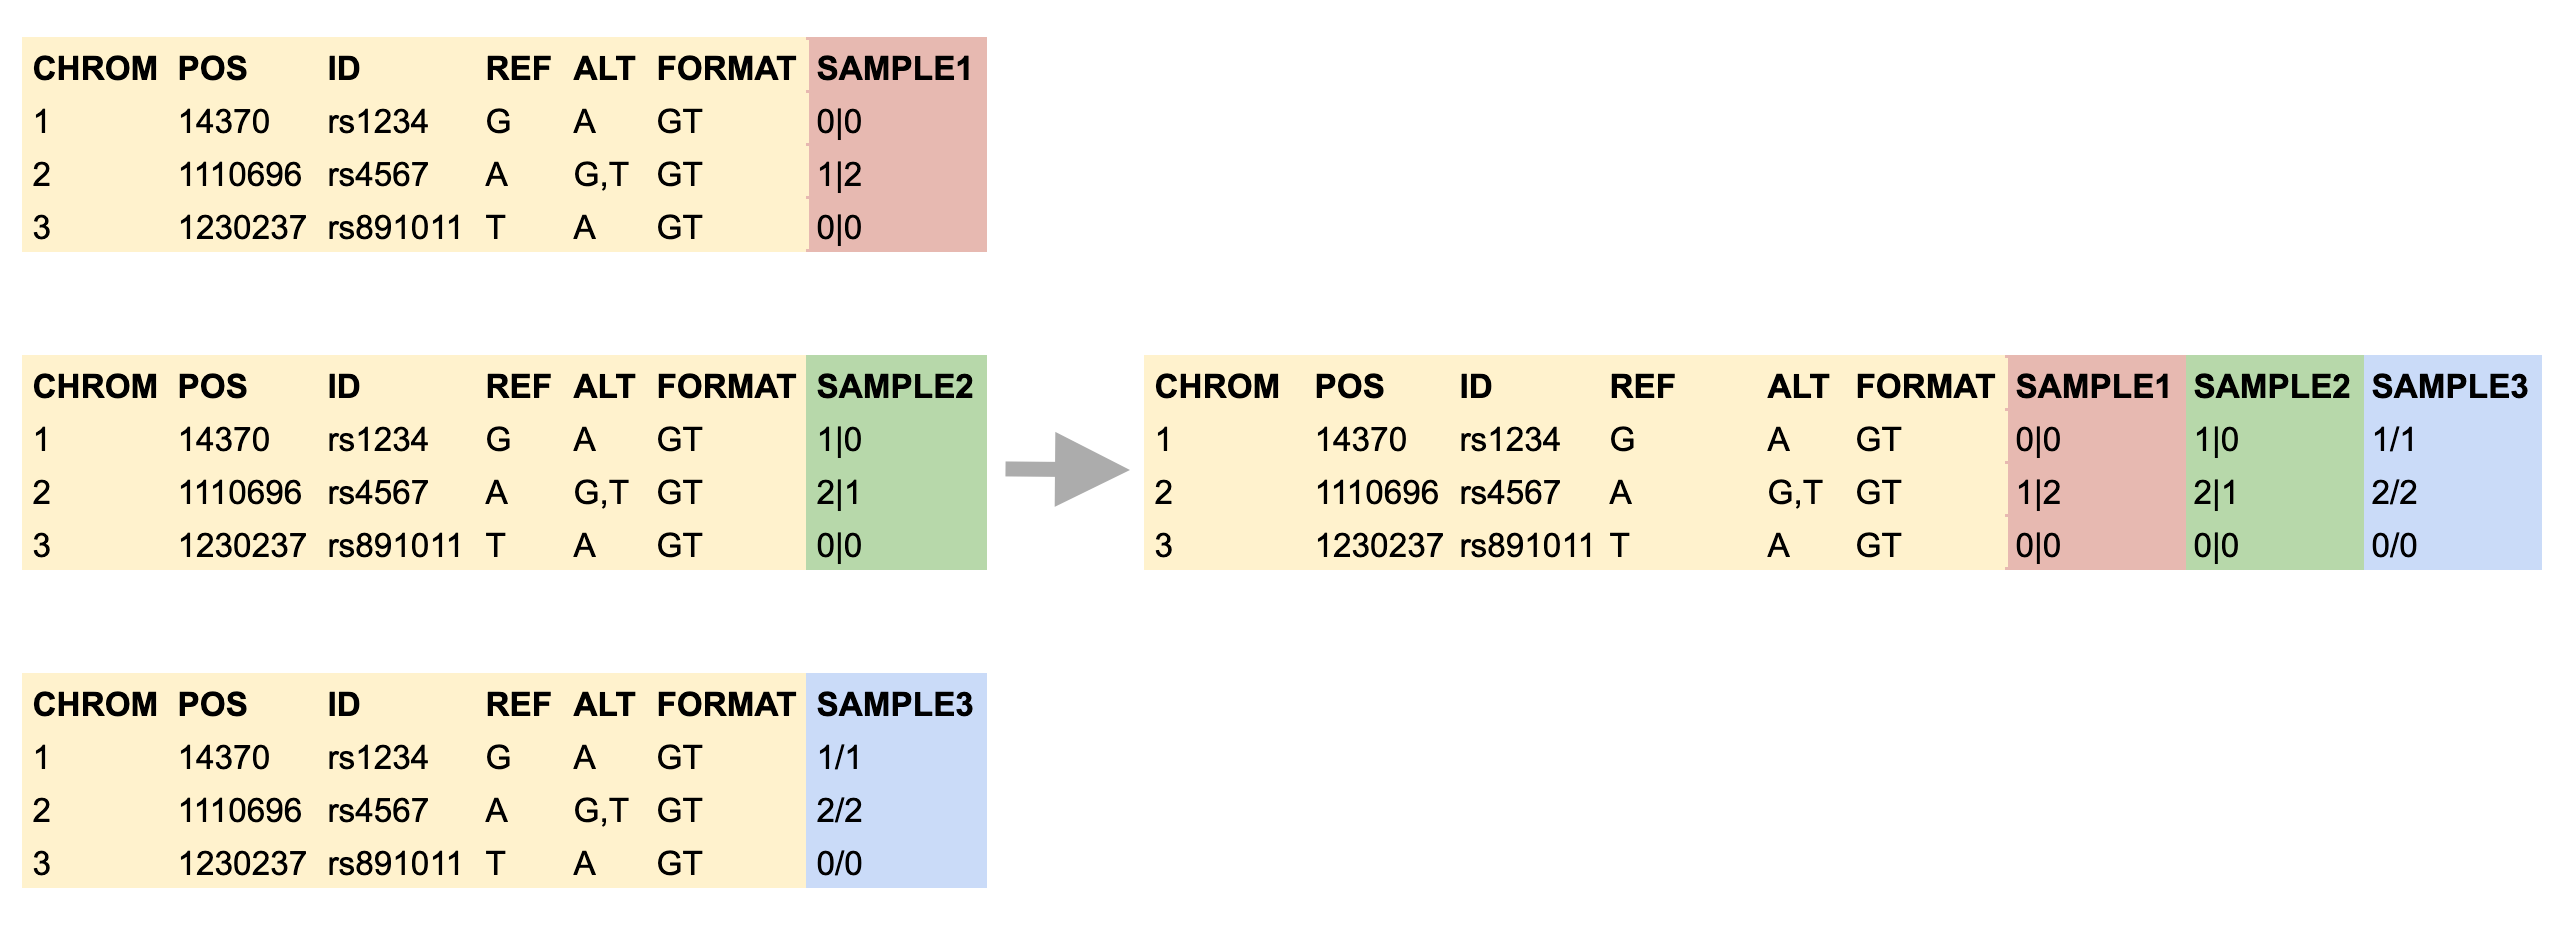


Ok, then let's merge two individuals:

```
bcftools merge -Oz -o merged_set.vcf.gz -g /home/local/ANTHROPOLOGY/kuhlwilmm83/refgen/hg19/hg19.p13.plusMT.no_alt_analysis_set.fa.gz chr18.vcf.gz chr18_b.vcf.gz
```

* Let's have a look at thes resulting file!

Speaking about multiple individuals...


## Diversity data

### 1000 Genomes data

The 1000 Genomes Project is a commonly-used reference data resources in human genetic studies.

In the (final) phase 3 data, there are 2,504 individuals from 26 populations ([Sudmant et al. 2015](https://doi.org/10.1038/nature15394)).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/1000_Genomes_Project.svg/1280px-1000_Genomes_Project.svg.png?1657572184698" alt="1KG" width="1000"/>

**Figure 2 [Locations](https://www.wikiwand.com/en/1000_Genomes_Project#/Human_genome_samples) of population samples of 1000 Genomes Project.** Each circle represents the number of sequences in the final release.

More information can be found in their [website](https://www.internationalgenome.org/).


# bcftools for multiple individuals

## Extract data from a population

So, we should get data from the 1000 Genomes project:

```
wget http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr18.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
```

This is a multi-individual VCF file. This it not in the `gvcf` format, making it easier to handle. To make it even easier, we may also subset the file. Let's have a look at the header as well as the metadata file provided by the project: 

```
bcftools index ALL.chr18.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz 
bcftools view -r chr18:1-25000000 -Oz -o chr18.vcf.gz ALL.chr18.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
bcftools view -h chr18.vcf.gz

wget http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel
less integrated_call_samples_v3.20130502.ALL.panel
```

It's already a rather big file, as you can see it does contain >2M records for 2,504 individuals, a data frame of *>2.7 billion cells*. Even for the smallest human chromosome (chr21), this is >1M records!

```
bcftools stats chr18.vcf.gz > stats_chr18.vcf.gz
bcftools index chr18.vcf.gz
```

The `index` step above is useful for retrieving subsets from the data, and generally recommendable for `vcf` files.

If we want to extract data from some individuals, for example, samples from the same population, we can use the argument `-S` with a file containing names of samples you want to extract. Let's assume you want to compare the Finns to the Iberians, you could use awk to create a nice list with the identifiers for each. (Btw, again a practical use case of a simple command line tool.)

```
awk '$2=="FIN" { print $1 }' integrated_call_samples_v3.20130502.ALL.panel > FIN.list
awk '$2=="IBS" { print $1 }' integrated_call_samples_v3.20130502.ALL.panel > IBS.list
```

Now, each line in these files contains one sample ID. Then we can extract genetic variants from the FIN and IBS populations with the following commands, respectively.

```
bcftools view -Oz -o chr21.FIN.vcf.gz chr21.vcf.gz -S FIN.list &
bcftools view -Oz -o chr21.IBS.vcf.gz chr21.vcf.gz -S IBS.list
```

* What does the `&` mean?
* Let's have a look at the files!


## Filtering data

As a result, you get a file containing the same variants as before, just for a subset of individuals instead of the whole thing.

When analysing data, we usually want to use variants that can meet some conditions, for example, variants with good quality. Then we can use several arguments to filter data in VCF files.

For example, the following commands extract biallelic single nucleotide polymorphisms (SNPs) that passed quality checks from the YRI and CEU populations.

```
bcftools view chr21.YRI.vcf.gz -f PASS -m 2 -M 2 -v snps | bgzip -c > chr21.YRI.biallelic.snps.vcf.gz
bcftools view chr21.CEU.vcf.gz -f PASS -m 2 -M 2 -v snps | bgzip -c > chr21.CEU.biallelic.snps.vcf.gz
```

* What is the meaning of the arguments `-f`, `-m`, `-M`, and `-v`?
* Ask bcftools directly: `bcftools view -h` 
* Or use the [manual](https://samtools.github.io/bcftools/bcftools.html#view)!



## Another analysis
-a -> compare

other bcftools things
